# Vollständige First-Level Analyse

### module importieren

In [1]:
import glob

import numpy as np
import pandas as pd
from sklearn import preprocessing

from nilearn import plotting, image, input_data
from nistats import first_level_model, reporting, regression

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Strukturelles Bild

In [2]:
mpr_img = '../data/sub-01_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz'

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/opt/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


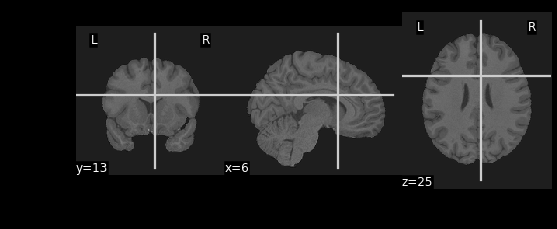

In [3]:
plotting.plot_anat(mpr_img);

### fMRT-Daten

In [4]:
fmri_img_list = glob.glob('../data/sub-01_task-imagery_run-0*_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
fmri_img_list.sort()
fmri_img_list = fmri_img_list[1:]
fmri_img_list

['../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
 '../data/sub-01_task-imagery_run-04_bold_space-MNI152NLin2009cAsym_preproc.nii.gz']

Beispiel:

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


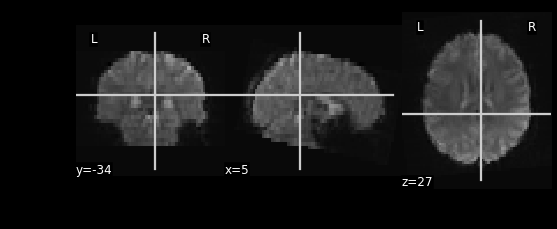

In [5]:
mean_epi_img = image.mean_img(fmri_img_list[-1])
plotting.plot_anat(mean_epi_img);

### alle runs hintereinanderhängen

In [6]:
fmri_imgs = image.concat_imgs(fmri_img_list)

wie viele Volumen sind in einem run?

In [7]:
n_volumes = image.load_img(fmri_img_list[-1]).shape[-1]
n_volumes

203

wie viele Volumen sind in der zusammengeführten Zeitserie?

In [8]:
fmri_imgs.shape

(65, 77, 40, 812)

### Das Design

In [9]:
onset_csvs = glob.glob('../data/sub-01_task-imagery_run-0*_events.tsv')
onset_csvs.sort()
onset_csvs = onset_csvs[1:]
onset_csvs

['../data/sub-01_task-imagery_run-01_events.tsv',
 '../data/sub-01_task-imagery_run-02_events.tsv',
 '../data/sub-01_task-imagery_run-03_events.tsv',
 '../data/sub-01_task-imagery_run-04_events.tsv']

Beispiel (letzter run):

In [10]:
pd.read_csv(onset_csvs[-1],sep='\t')

,onset,duration,trial_domain,trial_subdomain,trial_content
0,0,30,SPRACHE,Schreiben,Staedte
1,30,30,MOTORIK,Fuesse,Trampolin
2,60,30,GESICHTER,Beruehmt,Sportler
3,90,30,EMOTION,Positiv,Berg
4,120,30,RUHE,Ruhe,Ruhe
5,150,30,MOTORIK,Haende,Ballwerfen
6,180,30,EMOTION,Negativ,Strand
7,210,30,GESICHTER,Bekannt,Schulfreunde
8,240,30,SPRACHE,Sprechen,Vornamen
9,270,30,RUHE,Ruhe,Ruhe


### die zu analysierende Bedingung auswählen (trial_type)

In [11]:
def make_onsets(csv_file):
    df = pd.read_csv(csv_file,sep='\t')
    df.loc[:,'trial_num'] = [('0%s'%x)[-2:] for x in df.index.get_values().astype(str)]
    df.loc[:,'trial_type'] = df.loc[:,'trial_domain']
    return df

In [12]:
onset_df = make_onsets(onset_csvs[-1])
onset_df

,onset,duration,trial_domain,trial_subdomain,trial_content,trial_num,trial_type
0,0,30,SPRACHE,Schreiben,Staedte,00,SPRACHE
1,30,30,MOTORIK,Fuesse,Trampolin,01,MOTORIK
2,60,30,GESICHTER,Beruehmt,Sportler,02,GESICHTER
3,90,30,EMOTION,Positiv,Berg,03,EMOTION
4,120,30,RUHE,Ruhe,Ruhe,04,RUHE
5,150,30,MOTORIK,Haende,Ballwerfen,05,MOTORIK
6,180,30,EMOTION,Negativ,Strand,06,EMOTION
7,210,30,GESICHTER,Bekannt,Schulfreunde,07,GESICHTER
8,240,30,SPRACHE,Sprechen,Vornamen,08,SPRACHE
9,270,30,RUHE,Ruhe,Ruhe,09,RUHE


<font color=orange>__Modifikation:__ Statt trial_domain (die 5 Oberbedingungen), kann man auch eine andere Spalte der Onset-Tabelle nutzen um Bedingungen zu definieren</font>

### Aus den Onsets das Design erstellen

Meta-Informationen zu den runs

In [13]:
my_tr = 3
my_duration = n_volumes*my_tr
my_duration # dauer eines runs in sekunden (volumes x tr)

609

Onsets mit HRF verbinden

In [121]:
def make_design(df,my_tr=my_tr,my_duration=my_duration):
    frame_times = np.arange(0,my_duration,my_tr)
    design_matrix = first_level_model.make_first_level_design_matrix(frame_times=frame_times,
                                                                     events=df,
                                                                     drift_model='cosine'
                                                                    )
    return design_matrix

In [123]:
first_level_model.make_first_level_design_matrix?

Beispiel:

/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/opt/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


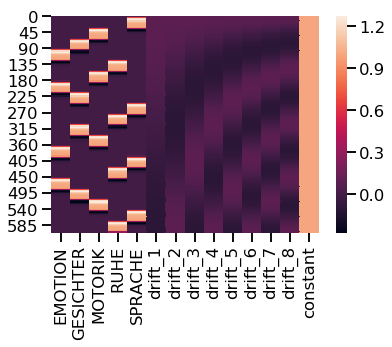

In [122]:
sns.heatmap(make_design(onset_df));

<font color=orange>__Modifikation:__ Drifts in das Modell aufnehmen (drift_model) check</font>

<font color=red>__Modifikation:__ Den Cutoff des High-Pass Filter verändern</font>

### Ein großes Design für alle 4 runs

In [16]:
def make_big_design(onset_csvs):
    
    design_matrix = pd.DataFrame()
    for run_num,onset_csv in enumerate(onset_csvs):
        this_onset = make_onsets(onset_csv)
        this_design = make_design(this_onset)
        this_design.index = this_design.index+my_duration*run_num
        design_matrix = pd.concat([design_matrix, this_design],sort=False)
        design_matrix = design_matrix.fillna(0)
        design_matrix.columns = ['%s-run%s'%(c,run_num) for c in design_matrix.columns]

    return design_matrix

In [17]:
design_matrix = make_big_design(onset_csvs)

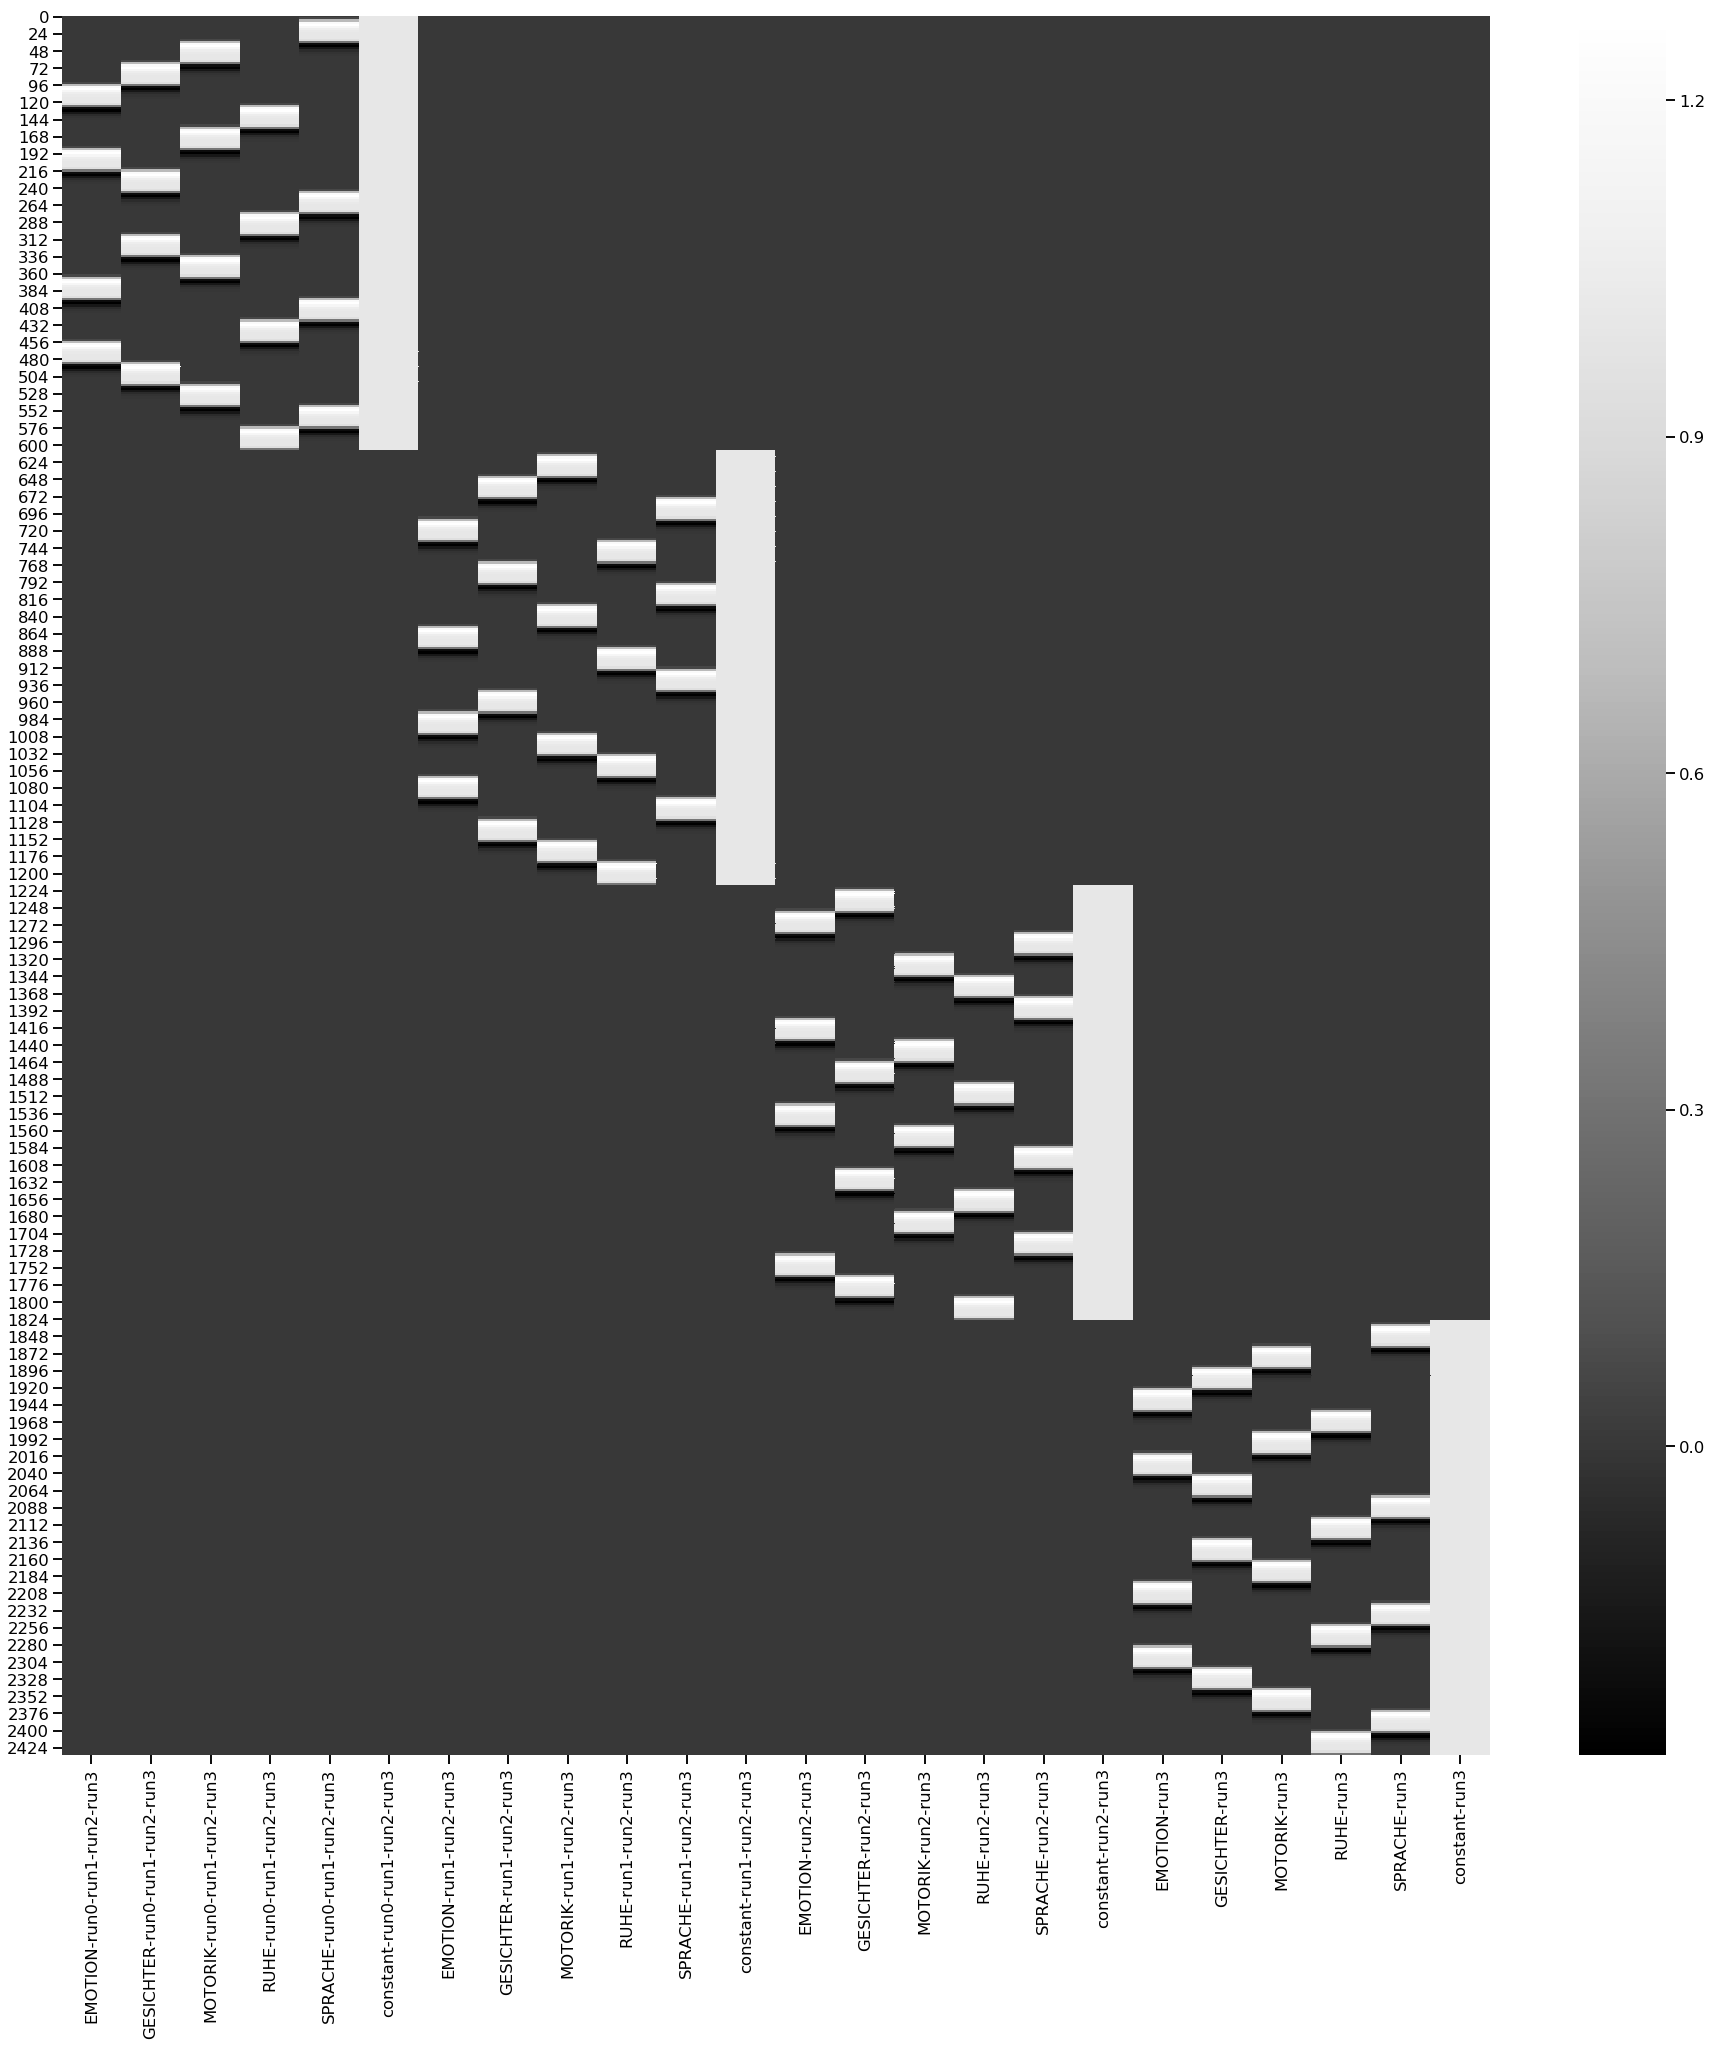

In [18]:
fig,ax = plt.subplots(1,1,figsize=(32,32))
sns.heatmap(design_matrix,ax=ax,cmap='Greys_r')
plt.show()

### Ein Modell welches Daten und Design verbindet

In [152]:
fmri_glm = first_level_model.FirstLevelModel(t_r=3,
                                             smoothing_fwhm=8,
                                             mask = '../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'
                                            )

<font color=green>__Modifikation:__ Der Grad an räumlicher Glättung kann variiert werden check</font>  
<font color=red>__Modifikation:__ Die Maske welche die zu analysierenden Voxel definiert kann aus ../data/ gewählt und hier angewendet werden check</font>

In [ ]:
fmri_glm2 = first_level_model.FirstLevelModel(t_r=3,
                                             smoothing_fwhm=10
                                            )

In [146]:
first_level_model.FirstLevelModel?

In [153]:
fmri_glm = fmri_glm.fit(fmri_imgs,design_matrices=design_matrix)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Welche Einstellungen hat das Modell?

In [154]:
fmri_glm

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover',
        mask='../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
        memory=Memory(location=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=8,
        standardize=False, subject_label=None, t_r=3, target_affine=None,
        target_shape=None, verbose=0)

Wie sieht der zu analysierende Bereich aus?

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


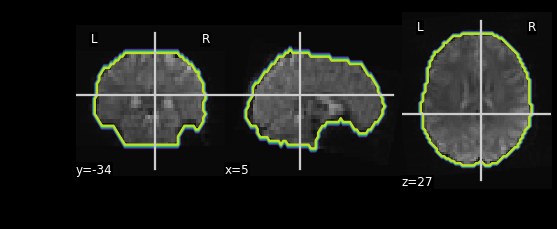

In [155]:
display = plotting.plot_anat(mean_epi_img)
display.add_contours(fmri_glm.masker_.mask_img_)

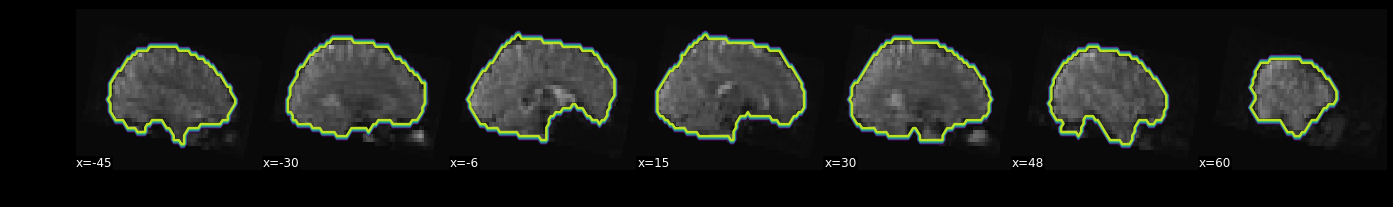

In [156]:
display = plotting.plot_anat(mean_epi_img,display_mode='x')
display.add_contours(fmri_glm.masker_.mask_img_)

### Wie korrelieren die Regressoren der Design-Matrix miteinander?

In [24]:
design_matrix = fmri_glm.design_matrices_[-1]

In [25]:
corr_df = design_matrix.corr()

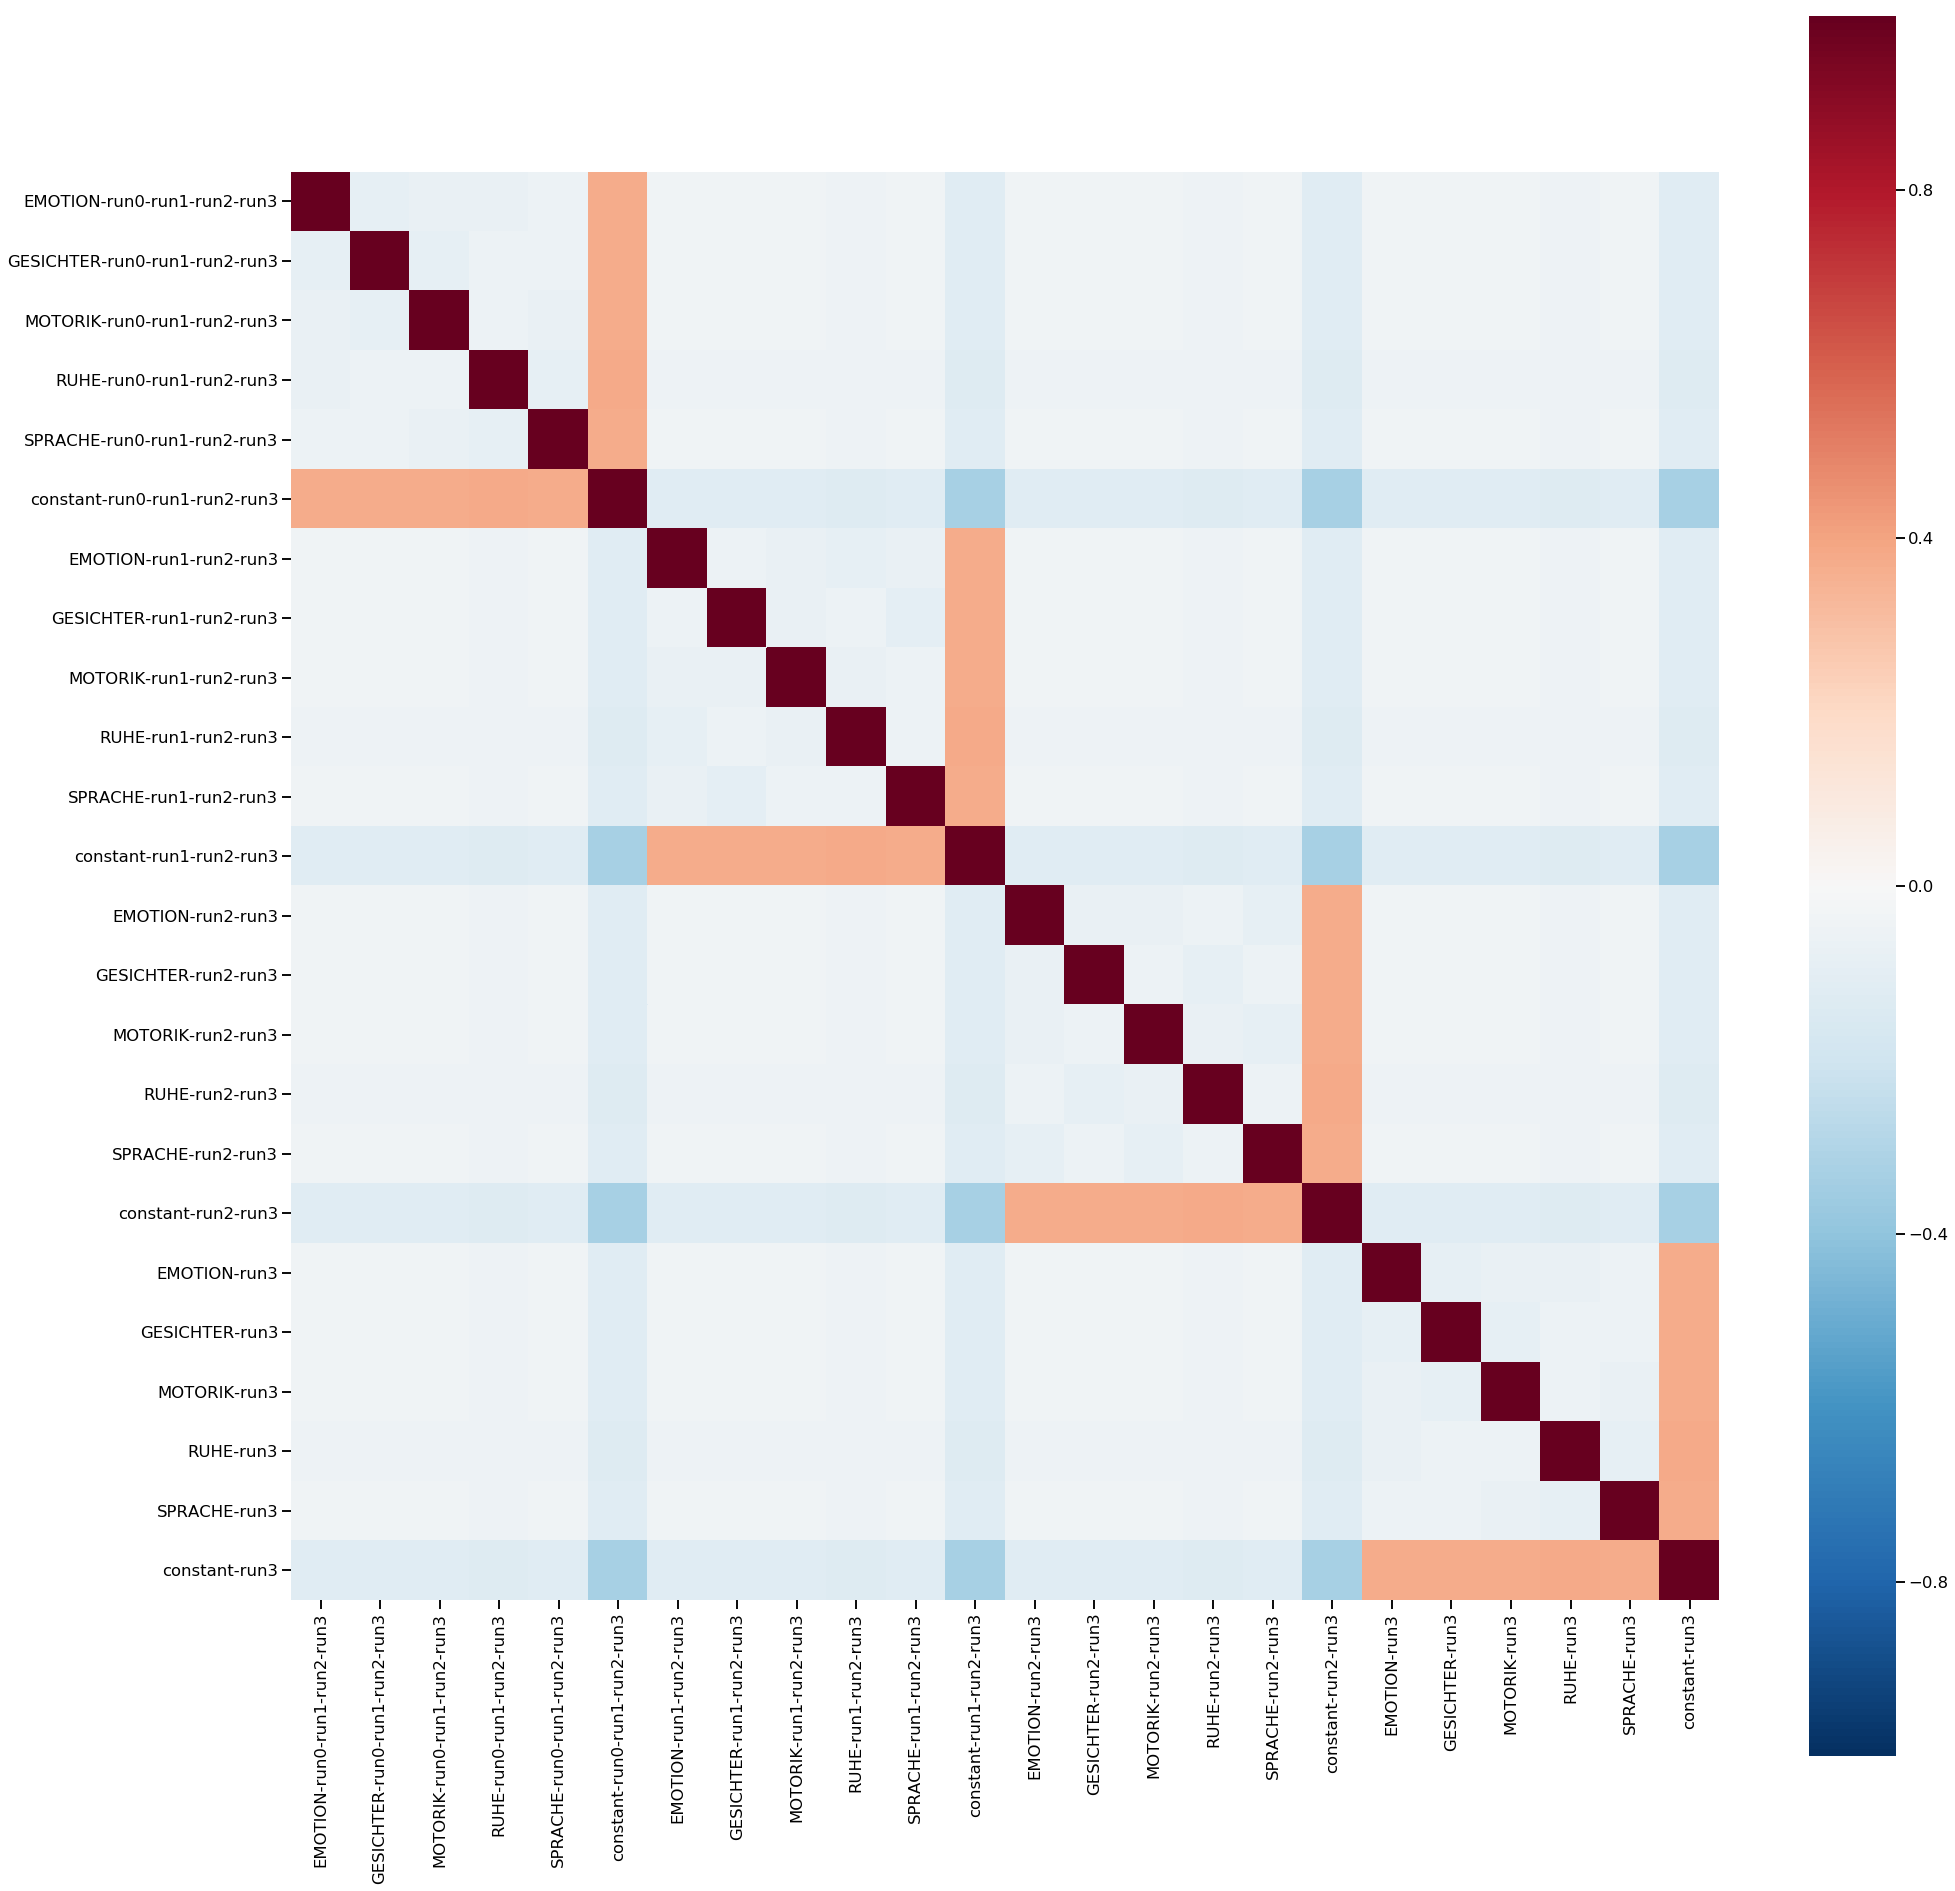

In [26]:
fig,ax = plt.subplots(1,1,figsize=(32,32))
sns.heatmap(corr_df,
            cmap='RdBu_r',
            square=True,
            vmin=-1,
            vmax=1,
            ax=ax)
plt.show()

## Ergebnisse berechnen

Wie viele runs haben wir?

In [27]:
n_runs = len(fmri_img_list)
n_runs

4

###  Die Bedingungen definieren

Jeder der Bedingungen wird mit 1en an den Stellen an denen sie in der Design-Matrix vorkommt definiert

In [39]:
conditions = {
    'emotion':   np.array([1., 0., 0., 0., 0., 0.]*n_runs),
    'gesichter': np.array([0., 1., 0., 0., 0., 0.]*n_runs),
    'motorik': np.array([0., 0., 1.,0., 0., 0.]*n_runs),
    'sprache': np.array([0., 0, 0.,0.,1., 0.]*n_runs),
    'ruhe': np.array([0., 0., 0., 1., 0., 0.]*n_runs),
    'constant': np.array([0., 0., 0., 0., 0., 1.]*n_runs),
}

In [40]:
def show_conds(conditions):
    con_df = pd.DataFrame(conditions).T
    plt.figure(figsize=(16,4))
    sns.heatmap(con_df,
                square=True,cbar=False,cmap='Greys_r',annot=True);
    plt.show()

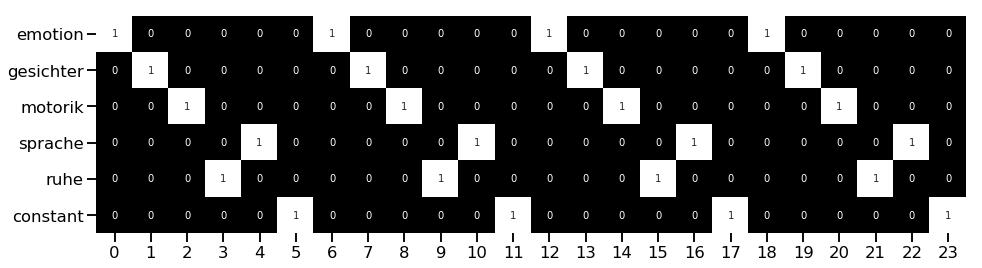

In [41]:
show_conds(conditions)

<font color=green>__Modifikation:__ Die fehlenden Bedingungen hinzufügen</font> check

### Einen Kontrast definieren

In [82]:
contrast = 1.0* conditions['emotion']+ 1*conditions['gesichter'] + 1*conditions['ruhe'] + 1*conditions['motorik']+ 1*conditions['sprache']  
contrast

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0.])

### ANOVA

<font color=green>__Modifikation:__ Andere Vergleiche von zwei Bedinungen rechnen check</font> 
<font color=orange>__Modifikation:__ Eine Bedingung gegen alle anderen vergleichen check</font>  
<font color=red>__Modifikation:__ Eine 1-faktorielle ANOVA mit 5 Stufen formulieren</font>

In [75]:
contrast2 = conditions['emotion'] - conditions['ruhe']

In [83]:
def show_conts(contrast,design_matrix=design_matrix):
    con_df = pd.DataFrame(contrast,index=design_matrix.columns).T
    plt.figure(figsize=(16,4))
    sns.heatmap(con_df,
                square=True,cbar=False,cmap='Greys_r',annot=True);
    plt.yticks([])
    plt.show()

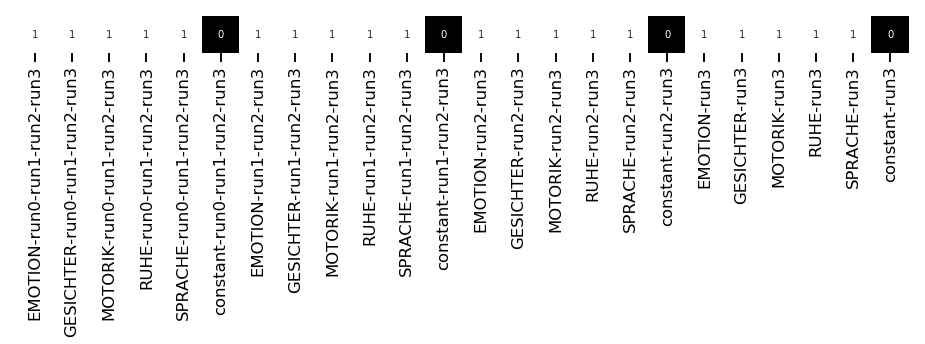

In [84]:
show_conts(contrast)

### Eine Ergebniskarte generieren

In [78]:
result_map = fmri_glm.compute_contrast(contrast)

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [140]:
result_map = fmri_glm.compute_contrast(contrast, stat_type = 't', output_type = 'stat')
p_map = fmri_glm.compute_contrast(contrast, stat_type = 't', output_type = 'p_value')

/opt/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [143]:
p_thresh = image.math_img('(img1<0.05)*img2',img1=p_map,img2=result_map)

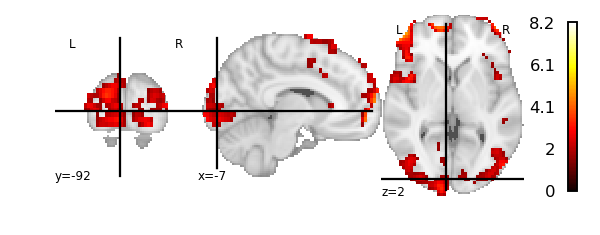

In [144]:
plotting.plot_stat_map(p_thresh)

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


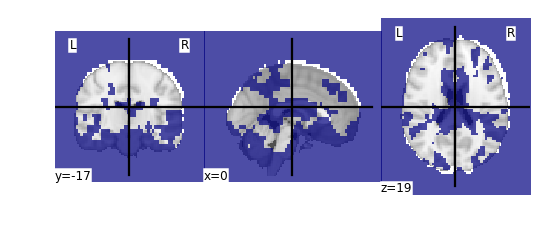

In [133]:
plotting.plot_roi(p_thresh)

<font color=green>__Modifikation:__ z-Werte, t-Werte und p-Werte plotten</font>  
<font color=red>__Modifikation:__ Eine 1-faktorielle ANOVA rechnen</font>

### Die Karte visualisieren

In [129]:
display = plotting.view_img(result_map,bg_img=mpr_img)

/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


<font color=green>__Modifikation:__ Einen anderen Schwellenwert auswählen</font>  
<font color=red>__Modifikation:__ Eine Karte mit t-Werten plotten, die bei p<0.001 gethresholded ist</font>  

In [145]:
display.open_in_browser()

/opt/miniconda3/lib/python3.7/subprocess.py:858: ResourceWarning: subprocess 1770 is still running
  ResourceWarning, source=self)
/opt/miniconda3/lib/python3.7/subprocess.py:858: ResourceWarning: subprocess 1776 is still running
  ResourceWarning, source=self)


<font color=green>__Modifikation:__ display in neuem Fenster im Vollbildmodus öffnen</font>  
<font color=red>__Modifikation:__ Eine Tabelle mit Aktivierungen als Koordinaten ausgeben lassen</font>